# Nonlinear algebra



Nonlinear algebra problems are typically solved using an iterative process that terminates when the solution is found within a specified tolerance. This process is hidden from the user. The canonical standard form to solve is $f(X) = 0$.


## Know your tolerance



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/02/know-your-tolerance/)


$V = \frac{\nu (C_{Ao} - C_A)}{k C_A^2}$


With the information given below, solve for the exit concentration. This should be simple.

    Cao = 2*u.mol/u.L;
    V = 10*u.L;
    nu = 0.5*u.L/u.s;
    k = 0.23 * u.L/u.mol/u.s;



In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# unit definitions
m = 1.0
L = m**3 / 1000.0
mol = 1.0
s = 1.0

# provide data
Cao = 2.0 * mol / L
V = 10.0 * L
nu = 0.5 * L / s
k = 0.23 * L / mol / s


def func(Ca):
    return V - nu * (Cao - Ca) / (k * Ca**2)

Let us plot the function to estimate the solution.



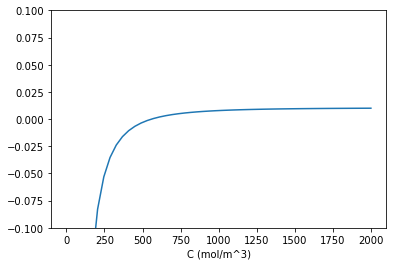

In [2]:
c = np.linspace(0.001, 2) * mol / L

plt.clf()
plt.plot(c, func(c))
plt.xlabel("C (mol/m^3)")
plt.ylim([-0.1, 0.1]);

Now let us solve the equation. It looks like an answer is near C=500.



In [3]:
from scipy.optimize import fsolve

cguess = 500
(c,) = fsolve(func, cguess)
print(c)
print(func(c))
print(func(c) / (mol / L))

559.5837456060607
-1.734723475976807e-18
-1.734723475976807e-21


Interesting. In Matlab, the default tolerance was not sufficient to get a good solution. Here it is.



## Solving integral equations with fsolve



[Original post in Matlab](http://matlab.cheme.cmu.edu/2011/08/30/solving-integral-equations/)

Occasionally we have integral equations we need to solve in engineering problems, for example, the volume of plug flow reactor can be defined by this equation: $V = \int_{Fa(V=0)}^{Fa} \frac{1}{r_a} dFa$ where $r_a$ is the rate law. Suppose we know the reactor volume is 100 L, the inlet molar flow of A is 1 mol/L, the volumetric flow is 10 L/min, and $r_a = -k Ca$, with $k=0.23$ 1/min. What is the exit molar flow rate? We need to solve the following equation:

$$100 = \int_{Fa(V=0)}^{Fa} \frac{1}{-k Fa/\nu} dFa$$

We start by creating a function handle that describes the integrand. We can use this function in the quad command to evaluate the integral.



In [4]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

k = 0.23
nu = 10.0
Fao = 1.0


def integrand(Fa):
    return -1.0 / (k * Fa / nu)


def func(Fa):
    integral, err = quad(integrand, Fao, Fa)
    return 100.0 - integral


vfunc = np.vectorize(func)

We will need an initial guess, so we make a plot of our function to get an idea.



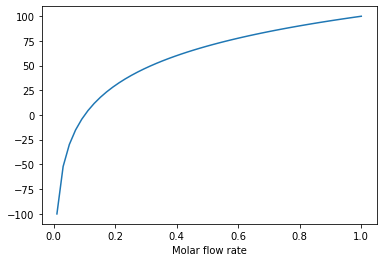

In [5]:
import matplotlib.pyplot as plt

f = np.linspace(0.01, 1)
plt.plot(f, vfunc(f))
plt.xlabel("Molar flow rate");

Now we can see a zero is near Fa = 0.1, so we proceed to solve the equation.



In [6]:
Fa_guess = 0.1
(Fa_exit,) = fsolve(vfunc, Fa_guess)
print("The exit concentration is {0:1.2f} mol/L".format(Fa_exit / nu))

The exit concentration is 0.01 mol/L


### Summary notes



This example seemed a little easier in Matlab, where the quad function seemed to get automatically vectorized. Here we had to do it by hand.



## Method of continuity for nonlinear equation solving



[Matlab post](http://matlab.cheme.cmu.edu/2011/11/01/method-of-continuity-for-nonlinear-equation-solving/)


Adapted from Perry's Chemical Engineers Handbook, 6th edition 2-63.

We seek the solution to the following nonlinear equations:

$2 + x + y - x^2 + 8 x y + y^3 = 0$

$1 + 2x - 3y + x^2 + xy - y e^x = 0$

In principle this is easy, we simply need some initial guesses and a nonlinear solver. The challenge here is what would you guess? There could be many solutions. The equations are implicit, so it is not easy to graph them, but let us give it a shot, starting on the x range -5 to 5. The idea is set a value for x, and then solve for y in each equation.



/Users/jkitchin/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/jkitchin/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


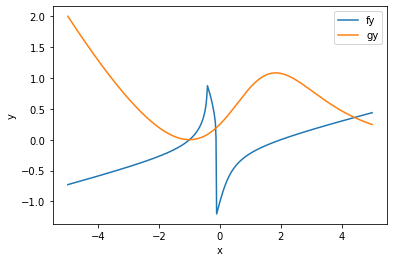

In [7]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt


def f(x, y):
    return 2 + x + y - x**2 + 8 * x * y + y**3


def g(x, y):
    return 1 + 2 * x - 3 * y + x**2 + x * y - y * np.exp(x)


x = np.linspace(-5, 5, 500)


@np.vectorize
def fy(x):
    x0 = 0.0

    def tmp(y):
        return f(x, y)

    (y1,) = fsolve(tmp, x0)
    return y1


@np.vectorize
def gy(x):
    x0 = 0.0

    def tmp(y):
        return g(x, y)

    (y1,) = fsolve(tmp, x0)
    return y1


plt.plot(x, fy(x), x, gy(x))
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["fy", "gy"]);

You can see there is a solution near x = -1, y = 0, because both functions equal zero there. We can even use that guess with fsolve. It is disappointly easy! But, keep in mind that in 3 or more dimensions, you cannot perform this visualization, and another method could be required.



In [8]:
def func(X):
    x, y = X
    return [f(x, y), g(x, y)]


print(fsolve(func, [-2, -2]))

[-1.00000000e+00  1.28730858e-15]


We explore a method that bypasses this problem today. The principle is to introduce a new variable, $\lambda$, which will vary from 0 to 1. at $\lambda=0$ we will have a simpler equation, preferably a linear one, which can be easily solved, or which can be analytically solved. At $\lambda=1$, we have the original equations. Then, we create a system of differential equations that start at the easy solution, and integrate from $\lambda=0$ to $\lambda=1$, to recover the final solution.

We rewrite the equations as:

$f(x,y) = (2 + x + y) + \lambda(- x^2 + 8 x y + y^3) = 0$

$g(x,y) = (1 + 2x - 3y) + \lambda(x^2 + xy - y e^x) = 0$

Now, at $\lambda=0$ we have the simple linear equations:

$x + y = -2$

$2x - 3y = -1$

These equations are trivial to solve:



In [9]:
x0 = np.linalg.solve([[1.0, 1.0], [2.0, -3.0]], [-2, -1])
print(x0)

[-1.4 -0.6]


We form the system of ODEs by differentiating the new equations with respect to $\lambda$. Why do we do that? The solution, (x,y) will be a function of $\lambda$. From calculus, you can show that:

$\frac{\partial f}{\partial x}\frac{\partial x}{\partial \lambda}+\frac{\partial f}{\partial y}\frac{\partial y}{\partial \lambda}=-\frac{\partial f}{\partial \lambda}$

$\frac{\partial g}{\partial x}\frac{\partial x}{\partial \lambda}+\frac{\partial g}{\partial y}\frac{\partial y}{\partial \lambda}=-\frac{\partial g}{\partial \lambda}$

Now, solve this for $\frac{\partial x}{\partial \lambda}$ and $\frac{\partial y}{\partial \lambda}$. You can use Cramer's rule to solve for these to yield:

\begin{eqnarray} \
\frac{\partial x}{\partial \lambda} &=& \frac{\partial f/\partial y \partial g/\partial \lambda - \partial f/\partial \lambda \partial g/\partial y}{\partial f/\partial x \partial g/\partial y - \partial f/\partial y \partial g/\partial x } \\\\
\frac{\partial y}{\partial \lambda} &=& \frac{\partial f/\partial \lambda \partial g/\partial x - \partial f/\partial x \partial g/\partial \lambda}{\partial f/\partial x \partial g/\partial y - \partial f/\partial y \partial g/\partial x } \end{eqnarray}

For this set of equations:

\begin{eqnarray} \
\partial f/\partial x &=& 1 - 2\lambda x + 8\lambda y \\\\
\partial f/\partial y &=& 1 + 8 \lambda x + 3 \lambda y^2 \\\\
\partial g/\partial x &=& 2 + 2 \lambda x + \lambda y - \lambda y e^x\\\\
\partial g/\partial y &=& -3 + \lambda x - \lambda e^x
\end{eqnarray}

Now, we simply set up those two differential equations on $\frac{\partial x}{\partial \lambda}$ and $\frac{\partial y}{\partial \lambda}$, with the initial conditions at $\lambda = 0$ which is the solution of the simpler linear equations, and integrate to $\lambda = 1$, which is the final solution of the original equations!



In [10]:
def ode(X, LAMBDA):
    x, y = X
    pfpx = 1.0 - 2.0 * LAMBDA * x + 8 * LAMBDA * y
    pfpy = 1.0 + 8.0 * LAMBDA * x + 3.0 * LAMBDA * y**2
    pfpLAMBDA = -(x**2) + 8.0 * x * y + y**3
    pgpx = 2.0 + 2.0 * LAMBDA * x + LAMBDA * y - LAMBDA * y * np.exp(x)
    pgpy = -3.0 + LAMBDA * x - LAMBDA * np.exp(x)
    pgpLAMBDA = x**2 + x * y - y * np.exp(x)
    dxdLAMBDA = (pfpy * pgpLAMBDA - pfpLAMBDA * pgpy) / (pfpx * pgpy - pfpy * pgpx)
    dydLAMBDA = (pfpLAMBDA * pgpx - pfpx * pgpLAMBDA) / (pfpx * pgpy - pfpy * pgpx)
    dXdLAMBDA = [dxdLAMBDA, dydLAMBDA]
    return dXdLAMBDA


from scipy.integrate import odeint

lambda_span = np.linspace(0, 1, 100)

X = odeint(ode, x0, lambda_span)

xsol, ysol = X[-1]
print("The solution is at x={0:1.3f}, y={1:1.3f}".format(xsol, ysol))
print(f(xsol, ysol), g(xsol, ysol))

The solution is at x=-1.000, y=0.000
-1.2774659896437804e-06 -1.1587381871538658e-06


You can see the solution is somewhat approximate; the true solution is x = -1, y = 0. The approximation could be improved by lowering the tolerance on the ODE solver. The functions evaluate to a small number, close to zero. You have to apply some judgment to determine if that is sufficiently accurate. For instance if the units on that answer are kilometers, but you need an answer accurate to a millimeter, this may not be accurate enough.

This is a fair amount of work to get a solution! The idea is to solve a simple problem, and then gradually turn on the hard part by the lambda parameter. What happens if there are multiple solutions? The answer you finally get will depend on your $\lambda=0$  starting point, so it is possible to miss solutions this way. For problems with lots of variables, this would be a good approach if you can identify the easy problem.



## Method of continuity for solving nonlinear equations - Part II



[Matlab post](http://matlab.cheme.cmu.edu/2011/11/02/method-of-continuity-for-solving-nonlinear-equations-part-ii-2/)

Yesterday in Post 1324 we looked at a way to solve nonlinear equations that takes away some of the burden of initial guess generation. The idea was to reformulate the equations with a new variable $\lambda$, so that at $\lambda=0$ we have a simpler problem we know how to solve, and at $\lambda=1$ we have the original set of equations. Then, we derive a set of ODEs on how the solution changes with $\lambda$, and solve them.

Today we look at a simpler example and explain a little more about what is going on. Consider the equation: $f(x) = x^2 - 5x + 6 = 0$, which has two roots, $x=2$ and $x=3$. We will use the method of continuity to solve this equation to illustrate a few ideas. First, we introduce a new variable $\lambda$ as: $f(x; \lambda) = 0$. For example, we could write $f(x;\lambda) = \lambda x^2 - 5x + 6 = 0$. Now, when $\lambda=0$, we hve the simpler equation $- 5x + 6 = 0$, with the solution $x=6/5$. The question now is, how does $x$ change as $\lambda$ changes? We get that from the total derivative of how $f(x,\lambda)$ changes with $\lambda$. The total derivative is:

$$\frac{df}{d\lambda} = \frac{\partial f}{\partial \lambda} + \frac{\partial f}{\partial x}\frac{\partial x}{\partial \lambda}=0$$

We can calculate two of those quantities: $\frac{\partial f}{\partial \lambda}$ and $\frac{\partial f}{\partial x}$ analytically from our equation and solve for $\frac{\partial x}{\partial \lambda}$ as

$$ \frac{\partial x}{\partial \lambda} = -\frac{\partial f}{\partial \lambda}/\frac{\partial f}{\partial x}$$

That defines an ordinary differential equation that we can solve by integrating from $\lambda=0$ where we know the solution to $\lambda=1$ which is the solution to the real problem. For this problem: $\frac{\partial f}{\partial \lambda}=x^2$ and $\frac{\partial f}{\partial x}=-5 + 2\lambda x$.



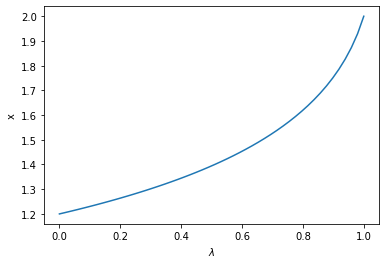

In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


def dxdL(x, Lambda):
    return -(x**2) / (-5.0 + 2 * Lambda * x)


x0 = 6.0 / 5.0
Lspan = np.linspace(0, 1)
x = odeint(dxdL, x0, Lspan)

plt.plot(Lspan, x)
plt.xlabel("$\lambda$")
plt.ylabel("x");

We found one solution at x=2. What about the other solution? To get that we have to introduce $\lambda$ into the equations in another way. We could try: $f(x;\lambda) = x^2 + \lambda(-5x + 6)$, but this leads to an ODE that is singular at the initial starting point. Another approach is $f(x;\lambda) = x^2 + 6 + \lambda(-5x)$, but now the solution at $\lambda=0$ is imaginary, and we do not have a way to integrate that! What we can do instead is add and subtract a number like this: $f(x;\lambda) = x^2 - 4 + \lambda(-5x + 6 + 4)$. Now at $\lambda=0$, we have a simple equation with roots at $\pm 2$, and we already know that $x=2$ is a solution. So, we create our ODE on $dx/d\lambda$ with initial condition $x(0) = -2$.



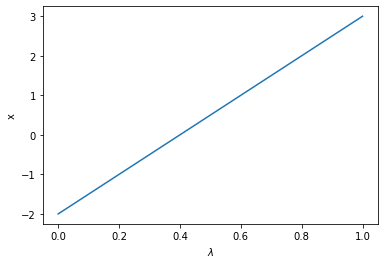

In [12]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


def dxdL(x, Lambda):
    return (5 * x - 10) / (2 * x - 5 * Lambda)


x0 = -2
Lspan = np.linspace(0, 1)
x = odeint(dxdL, x0, Lspan)

plt.plot(Lspan, x)
plt.xlabel("$\lambda$")
plt.ylabel("x");

Now we have the other solution. Note if you choose the other root, $x=2$, you find that 2 is a root, and learn nothing new. You could choose other values to add, e.g., if you chose to add and subtract 16, then you would find that one starting point leads to one root, and the other starting point leads to the other root. This method does not solve all problems associated with nonlinear root solving, namely, how many roots are there, and which one is "best" or physically reasonable? But it does give a way to solve an equation where you have no idea what an initial guess should be. You can see, however, that just like you can get different answers from different initial guesses, here you can get different answers by setting up the equations differently.



## Counting roots



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/10/counting-roots/)

The goal here is to determine how many roots there are in a nonlinear function we are interested in solving. For this example, we use a cubic polynomial because we know there are three roots.

$$f(x) = x^3 + 6x^2 - 4x -24$$



### Use roots for this polynomial



This ony works for a polynomial, it does not work for any other nonlinear function.



In [13]:
import numpy as np

print(np.roots([1, 6, -4, -24]))

[-6.  2. -2.]


Let us plot the function to see where the roots are.



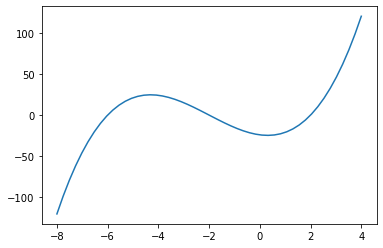

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-8, 4)
y = x**3 + 6 * x**2 - 4 * x - 24
plt.plot(x, y);

Now we consider several approaches to counting the number of roots in this interval. Visually it is pretty easy, you just look for where the function crosses zero. Computationally, it is tricker.



### Method 1



Count the number of times the sign changes in the interval. What we have to do is multiply neighboring elements together, and look for negative values. That indicates a sign change. For example the product of two positive or negative numbers is a positive number. You only get a negative number from the product of a positive and negative number, which means the sign changed.



In [15]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-8, 4)
y = x**3 + 6 * x**2 - 4 * x - 24

print(np.sum(y[0:-2] * y[1:-1] < 0))

3


This method gives us the number of roots, but not where the roots are.



### Method 2



Using events in an ODE solver python can identify events in the solution to an ODE, for example, when a function has a certain value, e.g. f(x) = 0. We can take advantage of this to find the roots and number of roots in this case. We take the derivative of our function, and integrate it from an initial starting point, and define an event function that counts zeros.

$$f'(x) = 3x^2 + 12x - 4$$

with f(-8) = -120



In [16]:
import numpy as np
from scipy.integrate import solve_ivp


def fprime(x, f):
    return 3.0 * x**2 + 12.0 * x - 4.0


def event(x, f):
    value = f  # we want f = 0
    return value


xspan = (-8, 4)
f0 = (-120,)

sol = solve_ivp(fprime, xspan, f0, events=event, max_step=0.1)

sol.t_events[0]  # these are the found roots

array([-6., -2.,  2.])

## Finding the nth root of a periodic function



There is a heat transfer problem where one needs to find the n^th root of the following equation: $x J_1(x) - Bi J_0(x)=0$ where $J_0$ and $J_1$ are the Bessel functions of zero and first order, and $Bi$ is the Biot number. We examine an approach to finding these roots.

First,  we plot the function.



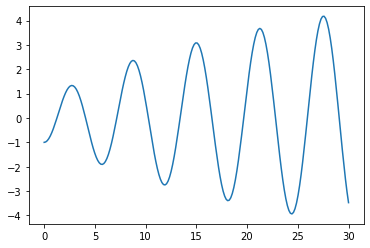

In [17]:
from scipy.special import jn, jn_zeros
import matplotlib.pyplot as plt
import numpy as np

Bi = 1


def f(x):
    return x * jn(1, x) - Bi * jn(0, x)


X = np.linspace(0, 30, 200)
plt.plot(X, f(X));

You can see there are many roots to this equation, and we want to be sure we get the n<sup>th</sup> root. This function is pretty well behaved, so if you make a good guess about the solution you will get an answer, but if you make a bad guess, you may get the wrong root. We examine next a way to do it without guessing the solution. What we want is the solution to $f(x) = 0$, but we want all the solutions in a given interval. We derive a new equation, $f'(x) = 0$, with initial condition $f(0) = f0$, and integrate the ODE with an event function that identifies all zeros of $f$ for us. The derivative of our function is $df/dx = d/dx(x J_1(x)) - Bi J'_0(x)$. It is known ([http://www.markrobrien.com/besselfunct.pdf](http://www.markrobrien.com/besselfunct.pdf)) that $d/dx(x J_1(x)) = x J_0(x)$, and $J'_0(x) = -J_1(x)$. All we have to do now is set up the problem and run it.



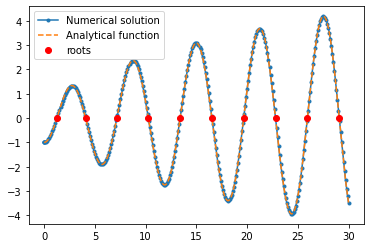

In [18]:
from pycse import *  # contains the ode integrator with events

from scipy.special import jn, jn_zeros
import matplotlib.pyplot as plt
import numpy as np

Bi = 1


def f(x):
    "function we want roots for"
    return x * jn(1, x) - Bi * jn(0, x)


def fprime(x, f):
    "df/dx"
    return x * jn(0, x) - Bi * (-jn(1, x))


def e1(x, f):
    "event function to find zeros of f"
    value = f
    return value


f0 = (f(0),)
xspan = (0, 30)

sol = solve_ivp(fprime, xspan, f0, events=e1, max_step=0.1)

plt.plot(sol.t, sol.y.T, ".-", label="Numerical solution")
plt.plot(sol.t, f(sol.t), "--", label="Analytical function")
plt.plot(sol.t_events[0], sol.y_events[0], "ro", label="roots")
plt.legend(loc="best");

You can work this out once, and then you have all the roots in the interval and you can select the one you want.



## Coupled nonlinear equations



Suppose we seek the solution to this set of equations:

\begin{align}
y &=& x^2 \\
y &=& 8 - x^2
\end{align}

To solve this we need to setup a function that is equal to zero at the solution. We have two equations, so our function must return two values. There are two variables, so the argument to our function will be an array of values.



In [19]:
from scipy.optimize import fsolve


def objective(X):
    x, y = X  # unpack the array in the argument
    z1 = y - x**2  # first equation
    z2 = y - 8 + x**2  # second equation
    return [z1, z2]  # list of zeros


x0, y0 = 1, 1  # initial guesses
guess = [x0, y0]
sol = fsolve(objective, guess)
print(sol)

# of course there may be more than one solution
x0, y0 = -1, -1  # initial guesses
guess = [x0, y0]
sol = fsolve(objective, guess)
print(sol)

[2. 4.]
[-2.  4.]
